In [2]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input

seed = 2023
np.random.seed(seed)  

In [3]:
def display_img(image, title=''):
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.show()

## 1) Resizing
The process is one of the options that is resizing images to a fixed size (128, 128).

In [2]:
def readAndResizeImages(data_dir, with_labels=True):
    height = 128
    width = 128
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize(image, [height, width])
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize(mask, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [3]:
X_train, Y_train, imageIDs_train = readAndResizeImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndResizeImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndResizeImages("./data/stage2_test_final", with_labels=False)

2023-05-03 15:37:11.321913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78997 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


The image id is 8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175, the dimension of the image is (256, 256) (width x height).
The original image


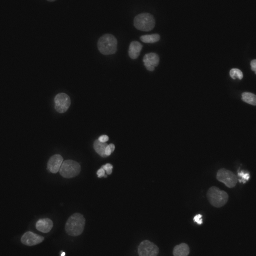

The original mask


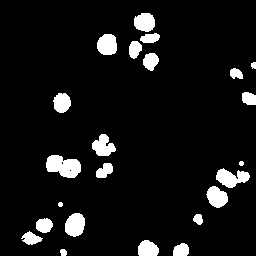

The image after resizing


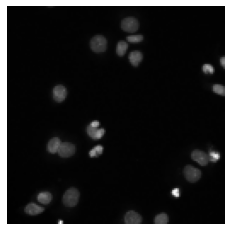

The mask after resizing


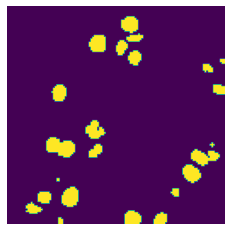

In [6]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

## 2) Resizing with padding
The process is one of the options that is padding images to a fixed size (256, 256). Resizes an image to a target width and height by keeping the aspect ratio the same without distortion. If the target dimensions don't match the image dimensions, the image is resized and then padded with zeroes to match requested dimensions.

In [7]:
def readAndresizepadImages(data_dir, with_labels=True):
    height = 256
    width = 256
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.resize_with_pad(image, height, width)
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.resize_with_pad(mask, height, width, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [8]:
X_train, Y_train, imageIDs_train = readAndresizepadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndresizepadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndresizepadImages("./data/stage2_test_final", with_labels=False)

The image id is 8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175, the dimension of the image is (256, 256) (width x height).
The original image


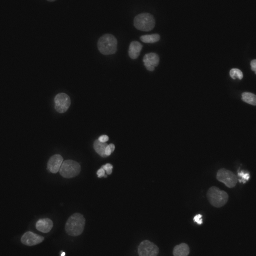

The original mask


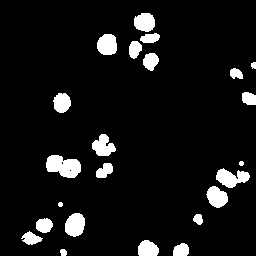

The image after resizing


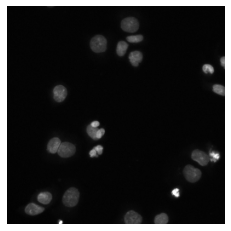

The mask after resizing


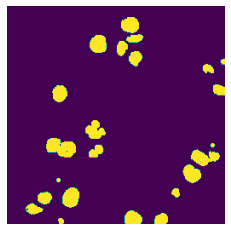

In [9]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

## 3) Ramdom cropping
Randomly crops a tensor to a given size.

In [10]:
def readAndramdomcropImages(data_dir, crop_times, with_labels=True):
    height = 128
    width = 128
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids* crop_times), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids* crop_times), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids) * crop_times):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i//crop_times]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        image = tf.image.random_crop(image, [height, width, 3])
        X[i] = image
        
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i//crop_times]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.random_crop(mask, [height, width, 3])[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [11]:
X_train, Y_train, imageIDs_train = readAndramdomcropImages("./data/stage1_train", 5)
X_val, Y_val, imageIDs_val = readAndramdomcropImages("./data/stage1_test", 5)
X_test, _, imageIDs_test = readAndramdomcropImages("./data/stage2_test_final", 5, with_labels=False)

The image id is 8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175, the dimension of the image is (256, 256) (width x height).
The original image


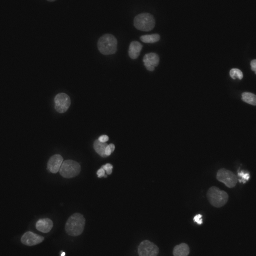

The original mask


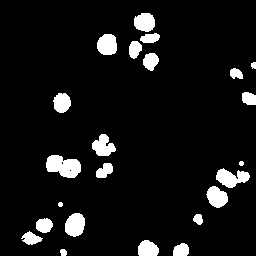

The image after resizing


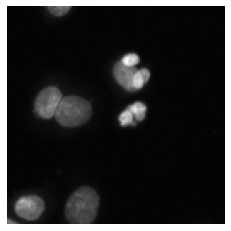

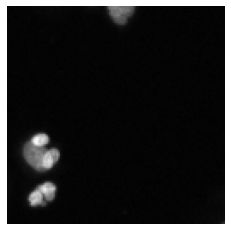

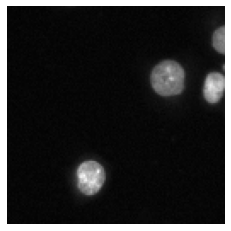

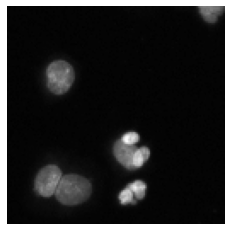

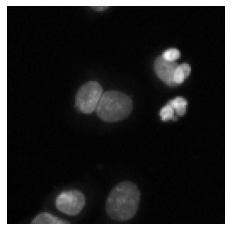

The mask after resizing


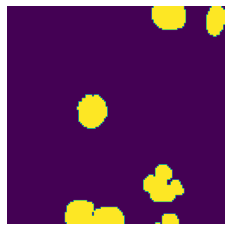

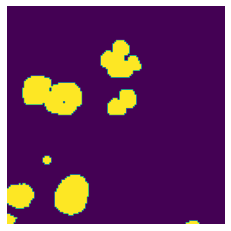

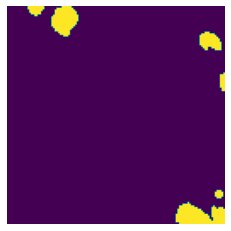

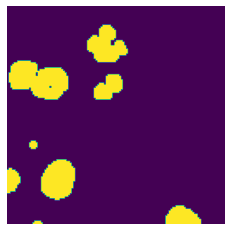

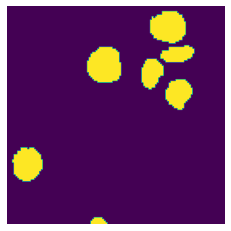

In [12]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
for idx1 in range(idx*5,idx*5+5):
    display_img(X_train[idx1])
print('The mask after resizing')
for idx1 in range(idx*5,idx*5+5):
    display_img(Y_train[idx1])

## 4) Padding
Pad image with zeros to the specified height and width.

In [5]:
def readAndpadImages(data_dir, with_labels=True):
    height = 1040
    width = 1388
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")
        offset_height = (height - image.size[1])//2
        offset_width = (width - image.size[0])//2
        image = tf.image.pad_to_bounding_box(image, offset_height, offset_width, height, width)
        X[i] = image
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.pad_to_bounding_box(mask, offset_height, offset_width, height, width)[:,:,:1]
            Y[i] = mask
    
    return X, Y, image_ids

In [ ]:
X_train, Y_train, imageIDs_train = readAndpadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndpadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndpadImages("./data/stage2_test_final", with_labels=False)

2023-05-03 15:54:19.617692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78997 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [ ]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])

## 5) Padding + cropping
first perform the padding processing to ensure the height and width is equal or above the design cropping size. In this case, the cropping size could be slightly higher without the contraint of minimal dimension of imagines of these three sets.

In [ ]:
def readAndcroppadImages(data_dir, with_labels=True):
    height = 256
    width = 256
    image_ids = os.listdir(data_dir)
    X = np.zeros((len(image_ids), height, width, 3), dtype=np.uint8)
    Y = np.zeros((len(image_ids), height, width, 1), dtype=np.bool_)
    for i in range(len(image_ids)):
        sample = {}

        path_images = f"{data_dir}/{image_ids[i]}/images"
        filename_image = os.listdir(path_images)[0]
        image = tf.keras.utils.load_img(f"{path_images}/{filename_image}")

        offset_height = (height - image.size[1])//2
        height0 = height
        width0 = width
        if offset_height < 0:
            height0 = image.size[1]
            offset_height = 0
        offset_width = (width - image.size[0])//2
        if offset_width < 0:
            width0 = image.size[0]
            offset_width = 0
        image = tf.image.pad_to_bounding_box(image, offset_height, offset_width, height0, width0)
        image = tf.image.random_crop(image, [height, width, 3])

        X[i] = image
        if with_labels:
            path_mask = f"{data_dir}/{image_ids[i]}/combined_masks"
            filename_mask = os.listdir(path_mask)[0]
            mask = tf.keras.utils.load_img(f"{path_mask}/{filename_mask}")
            mask = tf.image.pad_to_bounding_box(mask, offset_height, offset_width, height0, width0)[:,:,:1]
            mask = tf.image.random_crop(mask, [height, width, 1])
            Y[i] = mask
    
    return X, Y, image_ids

In [ ]:
X_train, Y_train, imageIDs_train = readAndcroppadImages("./data/stage1_train")
X_val, Y_val, imageIDs_val = readAndcroppadImages("./data/stage1_test")
X_test, _, imageIDs_test = readAndcroppadImages("./data/stage2_test_final", with_labels=False)

In [ ]:
idx = 2
img_size = Image.open(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png").size
print(f"The image id is {imageIDs_train[idx]}, the dimension of the image is {img_size} (width x height).")
print('The original image')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/images/{imageIDs_train[idx]}.png"))

print('The original mask')
display(DPImage(f"./data/stage1_train/{imageIDs_train[idx]}/combined_masks/{imageIDs_train[idx]}.png"))
print('The image after resizing')
display_img(X_train[idx])
print('The mask after resizing')
display_img(Y_train[idx])